<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/image_processing/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digitális képfeldolgozás

*Ez az összeálltás a gita Műszaki térinformatika egyesület 2022. évi konferenciájának a workshopjához készült. A tananyag és a használt képek a BME Általános és Felsőgeodézia Tanszék Geo4All laborjának [GitHub](https://github.com/OSGeoLabBp/tutorials/tree/master/hungarian/image_processing) oldaláról letölthetők*.

A képfeldolgozás (image processing), az alakfelismerés (pattern recognition) és a számítógépes grafika (computer graphics) is a digitális képekkel kapcsolatos informatikai területek. A képfeldolgozás során egy képből egy másik képet álltunk elő. Az alakfelismerés során a képből egy általában vektoros leírást állítunk elő, ezen a területen nagyon gyakran mesterséges intelligencia (gépi tanulás, mély tanulás, stb.) algoritmusokat használnak. A számítógépes grafika az általában vektoros leírásból a képet állítja elő.

Manapság a megjelenítő eszközeink szinte kívétel nélkül raszteresek, a kép az RGB kódok mátrixban elrendezett értékeit jelenti.


##Képi információk számítógépes kezelési területei

![Képi adatok kezelése](https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/img_proc.png)

Zömében képfeldolgozási kérdésekkel foglakozunk a következőkben, de a végén egy kis alakfelismerés is lesz.




---


**FIGYELEM ez a Jupyter Notebook csak Colab környezetben működik módosítások nélkül**
Saját vagy más Jupyter Notebook szolgáltatás vagy saját Python környezet esetén telepíteni kell több nem standard szoftvert (matplotlib, numpy, opencv/cv2, imutils, PIL), melyeket a Colab virtuális gépen alapból biztosítanak. A pytesseract könyvtárat és az ahhoz tartozó Python csomagot külön kell telepíteni a Colab esetén is.


---



In [1]:
# szükséges könyvtárak telepítése, betöltése
!sudo apt install tesseract-ocr  
!pip install pytesseract
import matplotlib.pyplot as plt   # matplotlib a grafikus megjelenítéshez
import numpy as np                # numpy a mátrix műveletekhez
import cv2                        # opencv könyvtár képfeldolgozáshoz
import imutils
import pytesseract                # szövegfelismeréshez

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,916 kB/s)
debconf: unable to initi

Leírás: egyenes (0,0) - (10,10) között


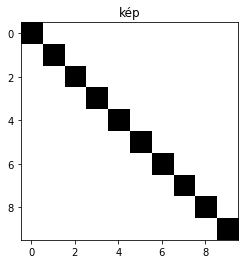

In [2]:
img = 255 - np.eye(10) * 255
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title('kép')
print('Leírás: egyenes (0,0) - (10,10) között')

**Figyelem** a kép origója a bal felső sarok!

A képfeldolgozás során egyik képből egy másik képet készítünk, ennek általában a célja, hogy a képből újabb vagy kévésbé kivehető információhoz jussunk. Tulajdonképpen a jelfeldolgozás egy speciális 2D-s változatával van dolgunk.



A digitális képeket a számítógépeken 2D-s vagy 3D-s tömbökben (mátrixokban tároljuk). A képek pixel sorokból és oszlopokból állnak. Az egyes pixelekben az adott pozicióban megjelenítendő szín kódolt értékét tároljuk. A színes képek esetén leggyakrabban RGB kódokat kezelünk, három 0-255 közötti értékekkel. A képfeldolgozás esetén gyakran áttérünk a szürkeárnyalatos vagy fekete-fehér képekre. Ezekben az esetekben képpontonként egy byte vagy egy bit is elegendő a szín információ tárolására.

In [3]:
# letöltünk egy képet a GitHub-ról
!wget -q -O sample_data/adalbert.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/20211022_133458.jpg

Több Python nyelvből használható ingyenes képfeldolgozási feladatokra alkalmas csomag/programkönyvtár is létezik. Ezek közül elsősorban az OpenCV-t használjuk majd, emellett a képek megjelentéséhez a Matplotlib szolgáltatásait vesszük igénybe.

Az érdeklődők számára, a teljesség igénye nélkül néhány további Pythonból elérhető képfeldolgozásra használható könyvtár:


*   [PIL/pillow](https://pillow.readthedocs.io/en/stable/) (Python Image Library)
*   [sckikit-image](https://scikit-image.org/)
*   [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html)
*   [ImageMagick](https://wiki.python.org/moin/ImageMagick)



##Szürkeárnyalatos és fekete-fehér képek előállítása színes képekből

A képfeldologzás során sokszor lecsökkentjük a képek színmélységét a feldolgozás egyszerűbbé és hatékonyabbá tétele érdekében.

színes képméret: (1536, 2048, 3), szürkeárnyalatos képméret: (1536, 2048)
Részlet a szürkeárnyalatos kép adataiból 10 x 15 pixel
[[198 194 198 192 196 202 197 196 187 192 193 185 183 191 195]
 [196 202 196 197 175 202 198 203 190 195 194 186 187 191 187]
 [208 203 199 199 184 193 198 192 188 200 195 198 190 192 191]
 [174 212 200 201 195 197 198 206 201 197 198 187 167 190 200]
 [181 205 200 192 182 199 193 192 195 197 199 199 201 198 185]
 [191 199 201 211 206 198 196 183 184 195 202 204 199 166 141]
 [178 204 202 204 194 194 195 200 198 205 191 164 119 139 159]
 [198 195 196 184 178 204 194 204 202 159 121 107 113 139 163]
 [190 189 188 192 196 207 200 157 121 121 133 138 156 173 176]
 [183 195 195 199 202 166 124 119 124 141 152 172 168 120  89]]


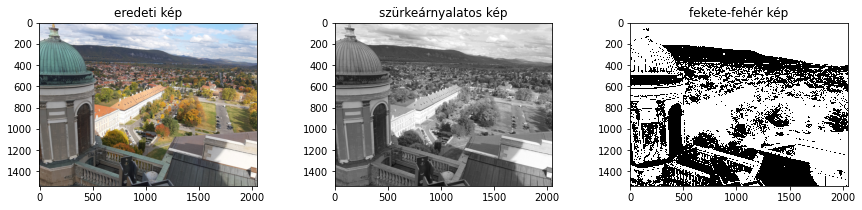

In [4]:
# kép betöltése
sample_bgr = cv2.imread('sample_data/adalbert.jpg')
# szürkeárnyalatos képpé konvertálás, az R, G, B értékeke átlaga
sample_gray = cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2GRAY)
# fekete-fehér kép a szürkeárnyalatosból, 0-th -> 0, th-255 -> 255
th = 100    # küszöbérték a szürkeárnylatra
thres, sample_bw = cv2.threshold(sample_gray, th, 255, cv2.THRESH_BINARY)
# képek megjelenítése
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
ax1.imshow(cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2RGB))
ax1.set_title('eredeti kép')
ax2.imshow(sample_gray, cmap='gray')
ax2.set_title('szürkeárnyalatos kép')
ax3.imshow(sample_bw, cmap='gray', interpolation='nearest')
ax3.set_title('fekete-fehér kép')
print(f'színes képméret: {sample_bgr.shape}, szürkeárnyalatos képméret: {sample_gray.shape}')
print('Részlet a szürkeárnyalatos kép adataiból 10 x 15 pixel')
print(sample_gray[800:810,830:845])

Módosítsa a küszöbértéket a fekete-fehér képpé konvertáláshoz (*th* változó a fenti kódban) és futtassa újra a blokkot!

###Adaptív küszöbérték

A fekete-fehér képpé konvertálás egy, az egész képre érvényes küszöbérték esetén sokszor nem megfelelő, főleg, ha árnyékos és napos részek is vannak a képen. Ebben az esetben az adaptív módszer célravezetőbb, a kép kisebb részeire eltérő küszöbértékeket használunk

390508275 389532900


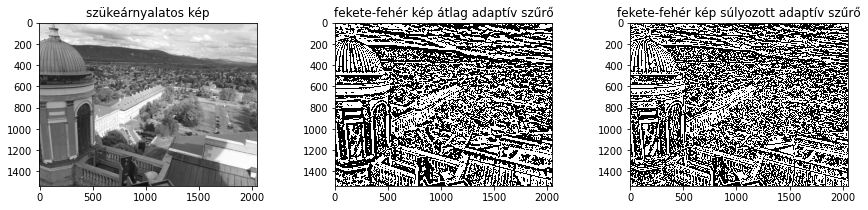

In [5]:
win = 51  # részterület mérete, melyre külön küszöbértéket állapítunk meg
const = 0 # az átlagból levont érték
# a részterületre eső pixelek átlaga a küszöbérték
bw1 = cv2.adaptiveThreshold(sample_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, win, const)
# a részterületre eső pixelek súlyozott átlaga a küszöbérték
bw2 = cv2.adaptiveThreshold(sample_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, win, const)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
ax1.imshow(sample_gray, cmap='gray')
ax1.set_title('szükeárnyalatos kép')
ax2.imshow(bw1, cmap='gray', interpolation='nearest')
ax2.set_title('fekete-fehér kép átlag adaptív szűrő')
ax3.imshow(bw2, cmap='gray', interpolation='nearest')
ax3.set_title('fekete-fehér kép súlyozott adaptív szűrő')
print(np.sum(bw1), np.sum(bw2))

Módosítsa a fenti kódban az adaptív szűrő paramétereit (*win* és *const* változók). A *win* változó a feldolgozandó részlet szélességét adja meg pixelekben, a *const* érték pedig a színkódból levonandó számérték.

##Konverzió különböző színterek között

A színes képek esetén különböző tárolási módok létezne. Ezek közül az RGB talán a legismertebb, mely esetén a vörös, zöld és kék csatorna értékét 0-255 közötti számmal ábrázoljuk. Az OpenCV könyvtár történelmi okokból BGR ábrázolást használ (a színek sorrendje eltérő). Emellett csakran használjuk a HSV (színárnyala, telítettség, érték) hármast. Például az azonos színű részek szűrése egyszerűbben oldható meg ebben a színtérben.

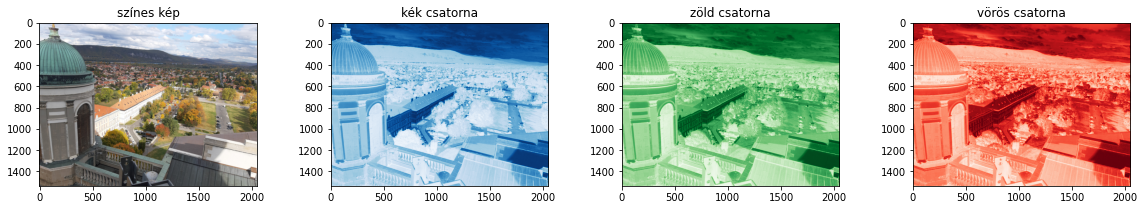

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 3))
ax1.imshow(cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2RGB))
ax1.set_title('színes kép')
ax2.imshow(sample_bgr[:,:,0], cmap='Blues')
ax2.set_title('kék csatorna')
ax3.imshow(sample_bgr[:,:,1], cmap='Greens')
ax3.set_title('zöld csatorna')
ax4.imshow(sample_bgr[:,:,2], cmap='Reds')
w = ax4.set_title('vörös csatorna')

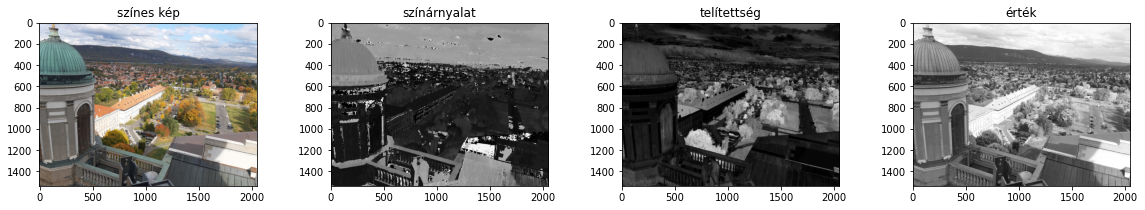

In [7]:
sample_hsv = cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2HSV)  # átalakítás HSV színtérbe
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 3))
ax1.imshow(cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2RGB))
ax1.set_title('színes kép')
ax2.imshow(sample_hsv[:,:,0], cmap='gray')
ax2.set_title('színárnyalat')
ax3.imshow(sample_hsv[:,:,1], cmap='gray')
ax3.set_title('telítettség')
ax4.imshow(sample_hsv[:,:,2], cmap='gray')
w = ax4.set_title('érték')

###Szín szerinti szűrés

Próbáljuk megtalálni egy képben a zöld területeket. Ehhez  a feladathoz célszerűbb HSV színtérben hozzálátni, mert ott egyszerűbben megoldható. Az egyes színeket a színárnyalat és telítettség értékek segítségével szűrhetjük.

![HS értékek](https://i.stack.imgur.com/gyuw4.png)

Az ábrán a vízszintes tengely a színárnyalat, a függőleges tengely pedig a telítettség. A zöld szín a 40-70 illetve 150-255 tartományba esik.

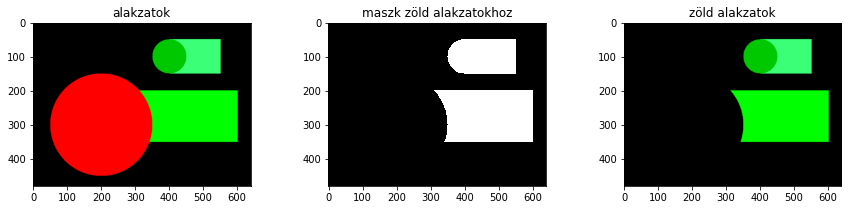

In [12]:
# létrehozunk egy képet fekete háttérrel
shapes = np.zeros((480, 640, 3), np.uint8)
# hozzáadunk néhány alakzatot
cv2.rectangle(shapes, (150, 200), (600, 350), (0, 255, 0), -1)
cv2.rectangle(shapes, (400, 50), (550, 150), (120, 255, 60), -1)
cv2.circle(shapes, (200, 300), 150, (0, 0, 255), -1)
cv2.circle(shapes, (400, 100), 50, (0, 200, 0), -1)
# BGR -> HSV átalakítás
shapes_hsv = cv2.cvtColor(shapes, cv2.COLOR_BGR2HSV)
# alsó, felső korlát zöldre (HSV)
lower_hsv_roof = np.array([40, 150, 20])
higher_hsv_roof = np.array([70, 255, 255])
mask = cv2.inRange(shapes_hsv, lower_hsv_roof, higher_hsv_roof)
green_shapes = cv2.bitwise_and(shapes, shapes, mask=mask)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
ax1.imshow(cv2.cvtColor(shapes, cv2.COLOR_BGR2RGB))
ax1.set_title('alakzatok')
ax2.imshow(mask, cmap='gray', interpolation='nearest')
ax2.set_title('maszk zöld alakzatokhoz')
ax3.imshow(cv2.cvtColor(green_shapes, cv2.COLOR_BGR2RGB))
w = ax3.set_title('zöld alakzatok')

##Kontraszt és fényesség

A kontraszt növelés a pixelek egy konstanssal szorzásával, a fényesség módosítása egy konstans hozzáadásával történhet meg. Ezek a módosítások az egész képre egységesen történnek meg, ezért a globális szűrők kategóriájába tartoznak.


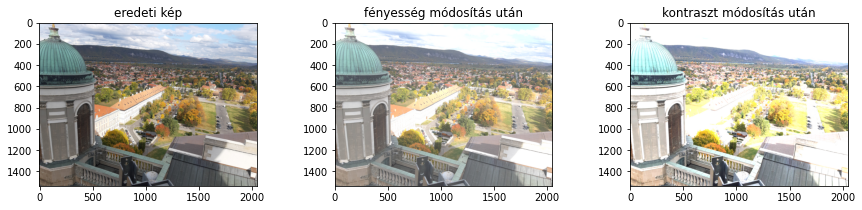

In [ ]:
alfa = 2.0   # szorzótényező kontraszt növeléséhez
beta = 50    # eltolás a fényesség módosításához
if beta > 0: # feltétel a 0-255 tartományra korlátozáshoz
  new_img1 = np.where(sample_bgr > 255 - beta, 255, sample_bgr + beta)
else:
  new_img1 = np.where(sample_bgr > abs(beta), sample_bgr + beta, 0)
if alfa > 1: # feltétel a 0-255 tartományra korlátozáshoz
  new_img2 = np.where(sample_bgr > 255 // alfa, 255, sample_bgr * alfa).astype('uint8')
else:
  new_img2 = np.clip(sample_bgr * alfa, 0, 255).astype('uint8')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,3))
ax1.imshow(cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2RGB))
ax1.set_title('eredeti kép')
ax2.imshow(cv2.cvtColor(new_img1, cv2.COLOR_BGR2RGB))
ax2.set_title('fényesség módosítás után')
ax3.imshow(cv2.cvtColor(new_img2, cv2.COLOR_BGR2RGB))
w = ax3.set_title('kontraszt módosítás után')


##Konvolúciós szűrők

A konvolúciós szűrők zajszűrésre (alúl áteresztő szűrők) és élkiemelésre (felül áteresztő szűrők) is használhatók. A szűrés során páratlan számú sorokból álló, súlyokat tartalmazó négyzetes mátrixot alkalmazunk minden pixelre a képben.A szűrt kép egyes képpontjainak a színét úgy kapjuk meg, hogy szűrő mátrix középső elemét a kép mátrix egy elemére illesztjük, a képben fedésbe került pixelek színértékét összeszorozzuk és a szorzatokat összegezzük. Például egy háromszor hármas minden elemében 1/9 értéket tartalmazó mátrix a pixel és a körülötte lévő nyolc pixel átlagát számítja, azaz simítani fog (zajszűrő).

simító szűrő
[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]
élkiemelő szűrő
[[-1 -1 -1]
 [-1  9 -1]
 [-1 -1 -1]]


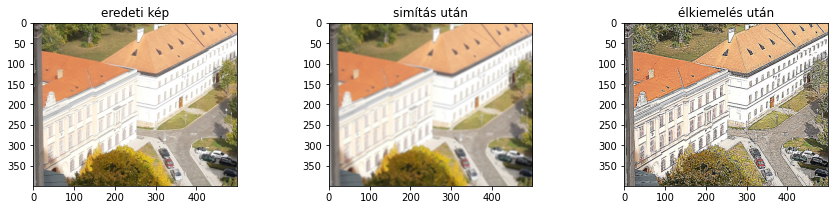

In [ ]:
# Zajszűrő (simító) szűrő
ksize1 = 5       # szűrő mérete
kernel1 = np.full((ksize1, ksize1), 1) / ksize1**2  # a szűrő elemeinek összege 1
blured = cv2.filter2D(sample_bgr, -1, kernel1)
# Élkiemelő szűrő
kmax = 9       # a szűrő középső eleme
ksize2 = 3
kernel2 = np.full((ksize2, ksize2), -1)
kernel2[ksize2 // 2, ksize2 // 2] = kmax
edges = cv2.filter2D(sample_bgr, -1, kernel2)
print('simító szűrő')
print(kernel1)
print('élkiemelő szűrő')
print(kernel2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
ax1.imshow(cv2.cvtColor(sample_bgr, cv2.COLOR_BGR2RGB)[700:1100,500:1000,:])
ax1.set_title('eredeti kép Részlet)')
ax2.imshow(cv2.cvtColor(blured, cv2.COLOR_BGR2RGB)[700:1100,500:1000,:])
ax2.set_title('simítás után (részlet)')
ax3.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)[700:1100,500:1000,:])
w = ax3.set_title('élkiemelés után (részlet)')

Módosítsa a szűrők paramétereit (ksize1, ksize2, kmax változók) és futtassa újra a kódblokkot!

Az OpenCV és más képfeldolgozó programok jóval több és a fentieknél összetettebb szűrőt is tartalmaznak. Néhány további kipróbálásra javasolt OpenCV szűrő:

*   GaussianBlur
*   MedianBlur
*   Sobel
*   ...


##Hisztogram kiegyenlítés

A különböző színárnyalatok gyakoriságát ábrázoló grafikon a hisztogram. Ha a hisztogram azt mutatja, hogy a színek egy része alulreprezentált, akkor a kép minőségét, részletességét a hisztogram kiegyenlítéssel javíthatjuk.

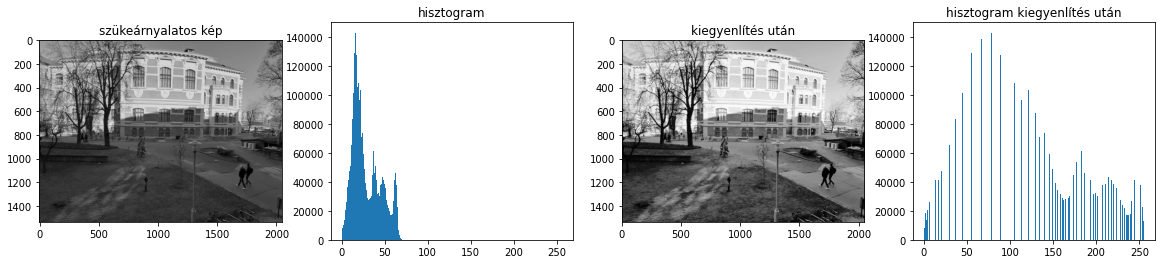

In [ ]:
!wget -q -O sample_data/ch.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/20220224_094651.jpg
test = cv2.imread('sample_data/ch.jpg', cv2.IMREAD_GRAYSCALE)
equ = cv2.equalizeHist(test)                          # hisztogram széthúzása
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
ax1.imshow(test, cmap='gray')
ax1.set_title('szükeárnyalatos kép')
ax2.hist(test.ravel(), 256, [0, 256])
ax2.set_title('hisztogram')
ax3.imshow(equ, cmap='gray')
ax3.set_title('kiegyenlítés után')
ax4.hist(equ.ravel(), 256, [0, 256])
w = ax4.set_title('hisztogram kiegyenlítés után')

###Több kép hisztogramjának kiegyenlítése

Ortofotókat általában több képből állítjuk össze. Ilyenkor, ha eltérő fényviszonyok között készülnek a felvételek, akkor a képeken eltérő színárnyalatokkal jelennek meg és a képek határa kirajzolódik. Ezt a hatást több kép hisztogramjának kiegyenlítésével szüntethetjük meg.

TODO: https://github.com/OSGeoLabBp/tutorials/blob/master/english/img_processing/code/image_equalize.py

##Vonalak keresése a képben

Töltsünk le egy-egy képet a kupola belsejéről és a környékről.

In [16]:
!wget -q -O sample_data/kupola.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/20211022_140346.jpg
!wget -q -O sample_data/mapillary.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/mapillary.png
!wget -q -O sample_data/chessboard.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/chessboard.png

A vonalak keresése előtt elő kell készíteni a képet. 


*   A képet fekete-fehérré alakítjuk
*   [Canny](https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html) eljárással az éleket kiemeljük
*   A [Hugh](https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html) eljárással vonalakat keresünk



In [28]:
def LineDetection(kupola, win, const):
  kupola_bw = cv2.adaptiveThreshold(kupola, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, win, const)
  kupola_bw = cv2.bitwise_not(kupola_bw)
  kupola_canny = cv2.Canny(kupola_bw, 100, 255, 3)
  linesP = cv2.HoughLinesP(kupola_canny, 1, np.pi / 180, 50, None, 50, 5)
  line_img = np.zeros(kupola_bw.shape).astype('uint8')
  if linesP is not None:
    for i in range(0, len(linesP)):
      l = linesP[i][0]
      cv2.line(line_img, (l[0], l[1]), (l[2], l[3]), 255, 2)
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
  ax1.imshow(kupola, cmap='gray')
  ax1.set_title('szürkeárnyalatos kép')
  ax2.imshow(kupola_bw, cmap='gray')
  ax2.set_title('fekete-fehér kép')
  ax3.imshow(kupola_canny, cmap='gray')
  ax3.set_title('detektált élek')
  ax4.imshow(line_img, cmap='gray')
  ax4.set_title('vonalak ' + str(linesP.shape[0]) )  

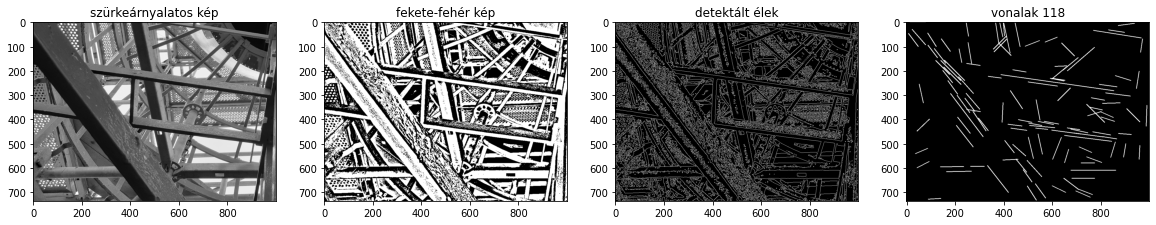

In [29]:
kupola = cv2.imread('sample_data/kupola.jpg', cv2.IMREAD_GRAYSCALE)
win = 51  # részterület mérete, melyre külön küszöbértéket állapítunk meg
const = 0 # az átlagból levont érték
LineDetection(kupola[800:,:1000], win, const) 

Végezze el a vonalak keresését a sample_data/mapillari.png képen is! Próbálja ki a globális küszöbérték használatát is!

Vizsgáljunk meg egy egyszerűbb képet is.

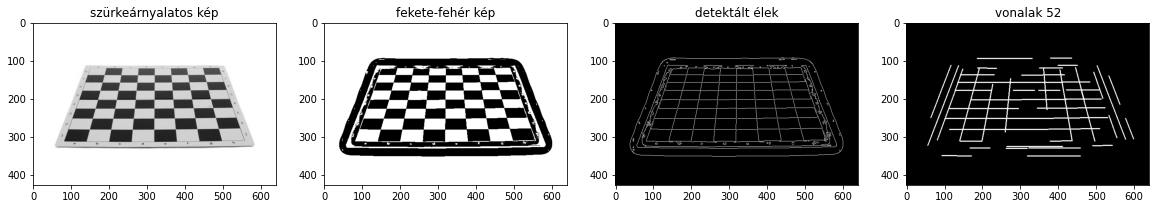

In [30]:
chess = cv2.imread('sample_data/chessboard.png', cv2.IMREAD_GRAYSCALE)
win = 51  # részterület mérete, melyre külön küszöbértéket állapítunk meg
const = 0 # az átlagból levont érték
LineDetection(chess, win, const)

Próbálja meg módosítani a paramétereket a vonalkeresésnél!

##Számjegyek felismerése

Egy komplex példa keretében tegyünk kísérletet számjegyek felismerésére. Annyival egyszerűsítjük a problémát, hogy a számjegyek csak egyenes szakaszokból állhatnak, mint a régebbi számológépek kijelzőjén.

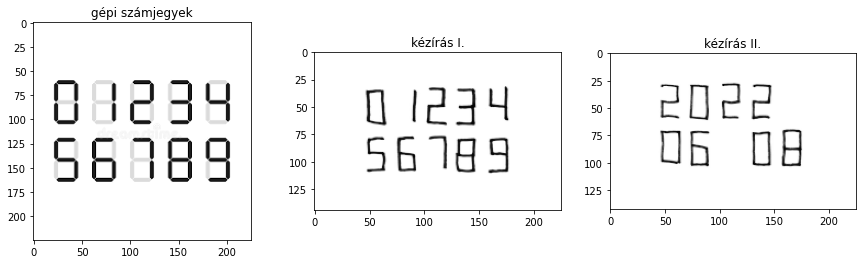

In [ ]:
!wget -q -O sample_data/numbers.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/numbers.png
numbers = cv2.imread('sample_data/numbers.png', cv2.IMREAD_GRAYSCALE)
!wget -q -O sample_data/hand_numbers1.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/hand_numbers1.png
numbers1 = cv2.imread('sample_data/hand_numbers1.png', cv2.IMREAD_GRAYSCALE)
!wget -q -O sample_data/hand_numbers2.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/hand_numbers2.png
numbers2 = cv2.imread('sample_data/hand_numbers2.png', cv2.IMREAD_GRAYSCALE)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.imshow(numbers, cmap='gray')
ax1.set_title('gépi számjegyek')
ax2.imshow(numbers1, cmap='gray')
ax2.set_title('kézírás I.')
ax3.imshow(numbers2, cmap='gray')
w = ax3.set_title('kézírás II.')


###Számfelismerés döntési fa lapján

In [ ]:
def key_areas(img, rect, tol):
    """ az összefüggő területen a hét lehetséges egyenes középpontjának 
        környezetében van érték?
        img : feldolgozandó kép
        rect: vizsgált terület bal, felső, szélesség, magasság
        tol: tolerancia, a pontok vizsgált környezete
            p0
        +---+---+
        |       |
     p3 +       + p4
        |   p1  |
        +---+---+
        |       |
     p5 +       + p6
        |   p2  |
        +---+---+
    """
    key_points = []   # üres lista a pontok koordinátáihoz
    key_points.append((rect[0] + int(rect[2] / 2), rect[1]))
    key_points.append((rect[0] + int(rect[2] / 2), int(rect[1] + rect[3] / 2)))
    key_points.append((rect[0] + int(rect[2] / 2), rect[1] + rect[3]))
    key_points.append((rect[0], int(rect[1] + rect[3] / 4)))
    key_points.append((rect[0] + rect[2], int(rect[1] + rect[3] / 4)))
    key_points.append((rect[0], int(rect[1] + rect[3] * 3 / 4)))
    key_points.append((rect[0] + rect[2], int(rect[1] + rect[3] * 3 / 4)))
    key_vals = np.zeros(7)  # hét elemű eredmény tömb
    for i in range(7):
        # fehér pixelek száma a pont környezetében
        key_vals[i] = np.sum(img[key_points[i][1]-tol:key_points[i][1]+tol,
                                 key_points[i][0]-tol:key_points[i][0]+tol]) / 255
    return key_vals



In [ ]:
def d_tree(w, kv, stat):
    """ döntési fa kulcspontok alapján a számjegy értékét adja vissza

        w: szám mező szélessége
        kv: kulcs területeken a fehér pixelek száma
        stat: statisztika a területre
    """
    if stat[2] < w / 4:     # keskeny
        num = 1
    else:
        n = sum([x > 0 for x in kv])    # vonalszegmensek száma
        num = -1
        if n == 7:
            num = 8         # minden segmensen vonal
        elif n == 6:        # 0/6/9
            if kv[1] == 0:
                num = 0
            elif kv[4] == 0:
                num = 6
            else:
                num = 9
        elif n == 5:        # 2/3/5
            if kv[0] * kv[4] * kv[1] * kv[5] * kv[2] > 0:
                num = 2
            elif kv[0] * kv[4] * kv[1] * kv[6] * kv[2] > 0:
                num = 3
            elif kv[0] * kv[3] * kv[1] * kv[6] * kv[2] > 0:
                num = 5
        elif n == 4 and kv[3] * kv[1] * kv[4] * kv[6] > 0:
            num = 4
        elif n == 3 and kv[0] * kv[4] * kv[6] > 0:
            num = 7
    return num

In [ ]:
def digits(nums):
    """ számjegyek keresése a képben

        nums: a feldolgozandó kép
    """
    # konvertálás kétszínűvé
    thres, nums_bw = cv2.threshold(nums, 127, 255, cv2.THRESH_BINARY)
    sq = np.full((3, 3), 1)                 # négyzetes maszk a hízlaláshoz

    nums_bw = cv2.bitwise_not(nums_bw)      # kép invertálása
    # hízlalás az esetleges hézagok kitöltéséhez
    nums_dilated = cv2.dilate(nums_bw, sq, iterations=2)
    # vékonyítás (csontváz)
    nums_thin = cv2.ximgproc.thinning(nums_dilated)
    # összefüggő részek
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(nums_thin, 8)
    limg = np.zeros(nums_bw.shape)  # üres (fekete) kép az eredményekhez
    w, h = np.median(stats[:, 2:4], axis=0)  # szélesség, magasság medián
    for i in range(1, num_labels):  # első a háttér átlépjük
        # befoglaló téglalap és centrális megjelenítése
        cv2.rectangle(limg, (stats[i][0], stats[i][1]),
                      (stats[i][0]+stats[i][2], stats[i][1]+stats[i][3]), 255, 1)
        cv2.circle(limg, (int(centroids[i][0]), int(centroids[i][1])), 2, 255)
        if stats[i][3] < h * 2 / 3 or stats[i][3] > h * 4 / 3:     # magasság nem ok
            continue
        # kulcs területek ellenőrzése
        kv = key_areas(nums_thin, stats[i], max(int(w / 6), 1))
        # döntési fa
        num = d_tree(w, kv, stats[i])
        # szám felirat
        cv2.putText(limg, str(num),
                    (int(centroids[i][0]), int(centroids[i][1])),
                    cv2.FONT_HERSHEY_SIMPLEX, max(int(w / 20), 1), 255)
    fig, ax = plt.subplots(1, 4, figsize=(20, 4))
    ax[0].imshow(nums_bw, cmap='gray')
    ax[0].set_title('Eredeti kép')
    ax[1].imshow(nums_dilated, cmap='gray')
    ax[1].set_title('Hízlalt vonalak')
    ax[2].imshow(nums_thin, cmap='gray')
    ax[2].set_title('Vékonyított vonalak')
    ax[3].imshow(limg, cmap='gray')
    ax[3].set_title('Megtalált számjegyek')

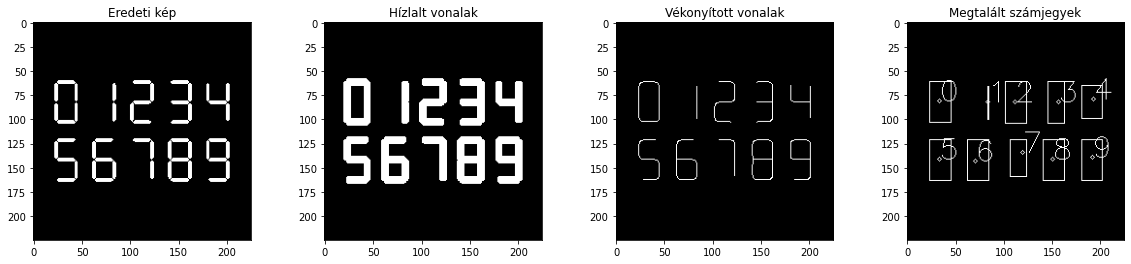

In [ ]:
nums = cv2.imread('sample_data/numbers.png', cv2.IMREAD_GRAYSCALE)
digits(nums)

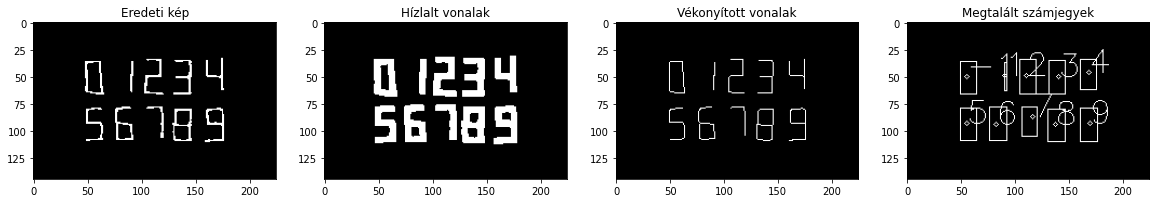

In [ ]:
nums1 = cv2.imread('sample_data/hand_numbers1.png', cv2.IMREAD_GRAYSCALE)
digits(nums1)

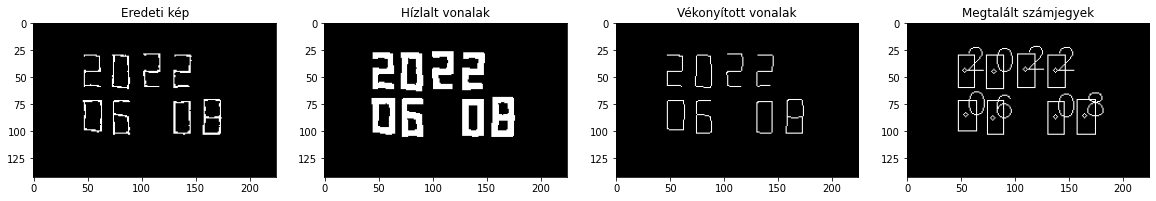

In [ ]:
nums2 = cv2.imread('sample_data/hand_numbers2.png', cv2.IMREAD_GRAYSCALE)
digits(nums2)

Próbálja ki a saját kézírásával készült számok felismerését!

Hogyan lehetne javítani a programon, hogy ferde és íves számokat is felismerjen?

##Rendszámtábla felismerés

A rendszámtábla felismerő rendszerekkel nap mint nap találkozhatunk az autópályákon, a mélygarázsokban, stb. A következőkben bemutatott megoldás kész eljárást használ fel a karakterek felismerésére. Ennek alapfeltétele, hogy a szöveget tartalmazó részt el tudjuk különíteni a kép többi részétől. A *tesseract* neurális hálózatokat alkalmaz a megoldás során.

In [ ]:
# kép letöltése
!wget -q -O sample_data/plate1.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/image_processing/data/plate1.png

Előkészítés, a lehetséges rendszám kivágása a képből.

NLE-003
 341 315 434 694
NLE-003
 341 315 434 694
ENE
 350 323 418 690


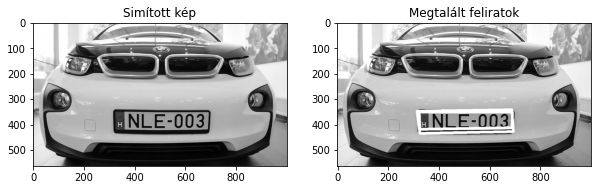

In [ ]:
gray = cv2.imread('sample_data/plate1.png', cv2.IMREAD_GRAYSCALE)
orig = gray.copy()    # eredeti kép megőrzése megjelenítéshez
gray = cv2.bilateralFilter(gray, 11, 17, 17) # zajcsökkentés/simítás
edged = cv2.Canny(gray, 30, 200) # élek detektálása
# zárt idomok kersése, nagyobbak megtartása
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10] # első 10 zárt idom terület szerint
for c in cnts:
  # körvonal simítása
  peri = cv2.arcLength(c, True)
  screenCnt = cv2.approxPolyDP(c, 0.018 * peri, True)
  if len(screenCnt) == 4:      # négy pontból áll a körvonal?
    # maszk a rendszám kivételéhez
    mask = np.zeros(gray.shape,np.uint8)
    new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)  # kitöltött körvonal rátétele a maszkra
    new_image = cv2.bitwise_and(gray,gray,mask=mask)          # körvonalon kívüli rész kitörlése
    (x, y) = np.where(mask == 255)                            # fehér pixelek
    (topx, topy) = (np.min(x), np.min(y))                     # befoglaló téglalap
    (bottomx, bottomy) = (np.max(x), np.max(y))
    cropped = gray[topx:bottomx+1, topy:bottomy+1]            # kivágás a simított képből
    text = pytesseract.image_to_string(cropped, config='--psm 11')   # rendszám leolvasása
    print(text, topx, topy, bottomx, bottomy)
    cv2.polylines(orig, [screenCnt], True, 255, 10)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(gray, cmap='gray')
ax[0].set_title('Simított kép')
ax[1].imshow(orig, cmap='gray')
w = ax[1].set_title('Megtalált feliratok')

Felhasznált források:


1.  https://github.com/OSGeoLabBp/tutorials/blob/master/hungarian/python/python3_oktato.rst
2.  https://www.tutorialspoint.com/dip/image_processing_introduction.htm
3.  https://docs.opencv.org/3.4/d6/d00/tutorial_py_root.html
4.  https://medium.com/swlh/image-processing-with-python-connected-components-and-region-labeling-3eef1864b951
5.  https://circuitdigest.com/microcontroller-projects/license-plate-recognition-using-raspberry-pi-and-opencv
6.  https://bhadreshpsavani.medium.com/how-to-use-tesseract-library-for-ocr-in-google-colab-notebook-5da5470e4fe0
8.  https://medium.com/@gowtham180502/how-to-detect-colors-using-opencv-python-98aa0241e713